# Initial configuration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, os
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
CACHE_DIR = "/scratch/chaijy_root/chaijy0/sstorks/.cache/huggingface"
os.environ['HF_HOME'] = CACHE_DIR

1.13.0+cu117
cuda


# CaptainCook4D Data Loading

In [3]:
VIDEO_DIR = "/nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/data/captain_cook_4d/hololens/sync/pv" # Directory containing CaptainCook4D mp4s
ANNOTATIONS_DIR = "/nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/annotations"

Boilerplate code to load video frames from video files (from GPT4):

In [4]:
import cv2
import numpy as np

def get_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError("Cannot open video file")
    
    return cap
    # remember to call cap.release() later

def extract_frames(cap, times):
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frames = []

    for t in times:
        frame_number = int(t * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            # Convert to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)            
            frames.append(frame)
        else:
            print(f"Warning: Frame at time {t} seconds could not be read.")
            frames.append(None)

    return frames

Other utils functions:

In [5]:
def generate_float_series(start, end, step):
    # Ensure step is a positive float
    step = abs(step)

    # Initialize the series with the start value
    series = [start]

    # Generate numbers in the series
    while start + step <= end:
        start += step
        series.append(start)

    # Check if the end value is already in the series
    if series[-1] != end:
        series.append(end)

    return series

Sample video: /nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/data/captain_cook_4d/hololens/sync/pv/29_7_360p.mp4
Recipe name: Caprese Bruschetta


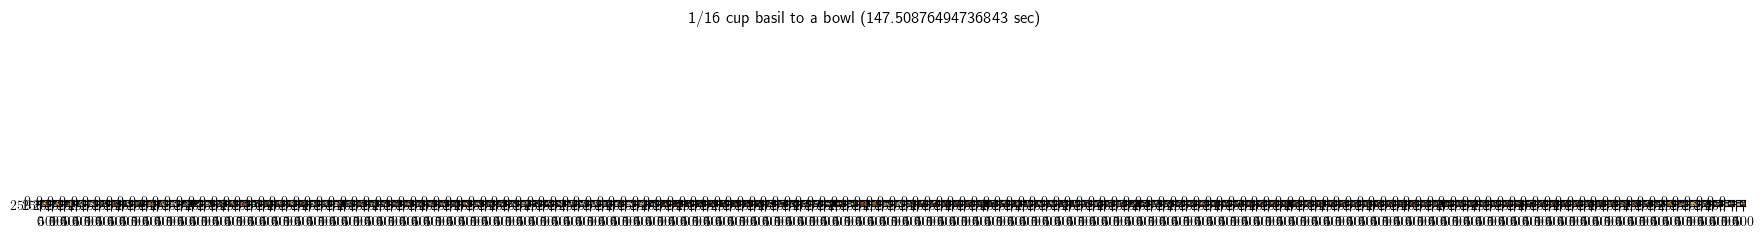

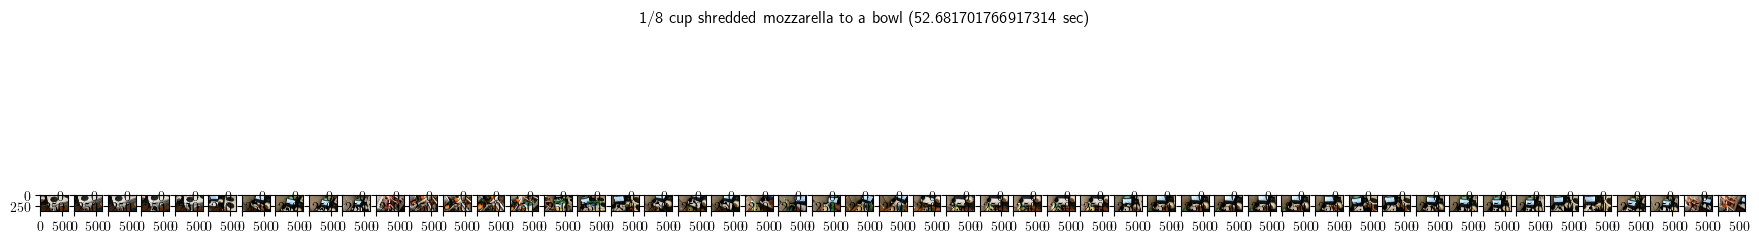

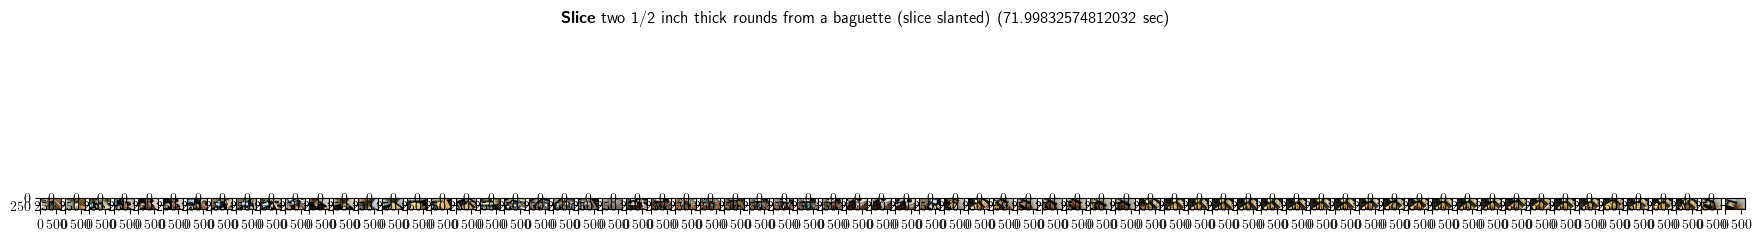

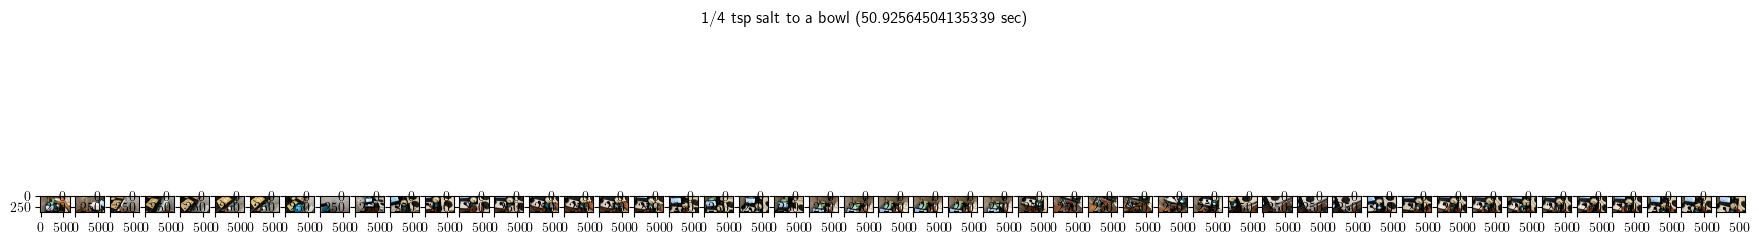

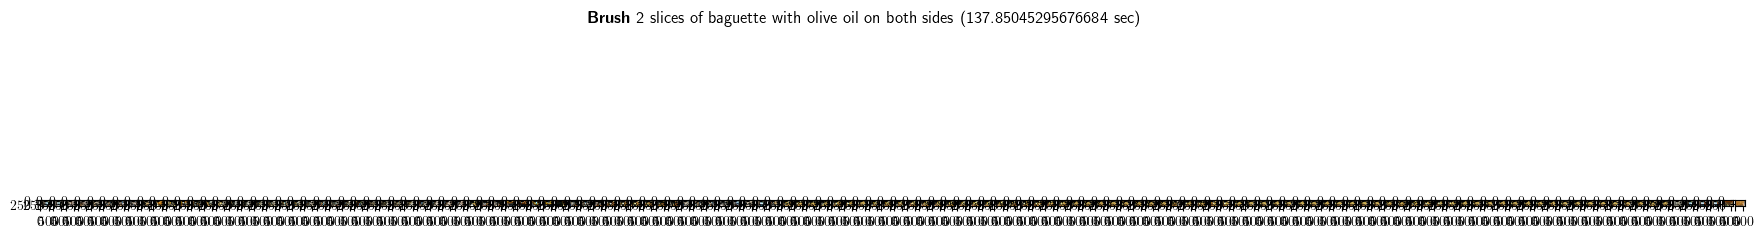

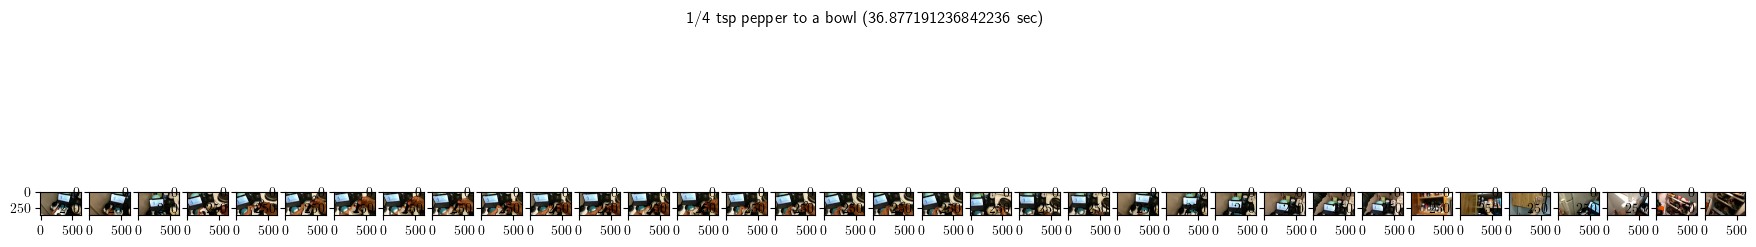

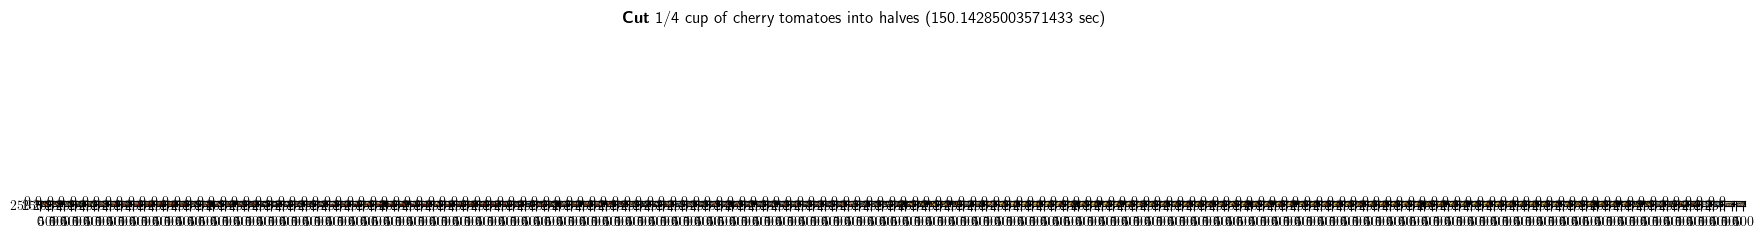

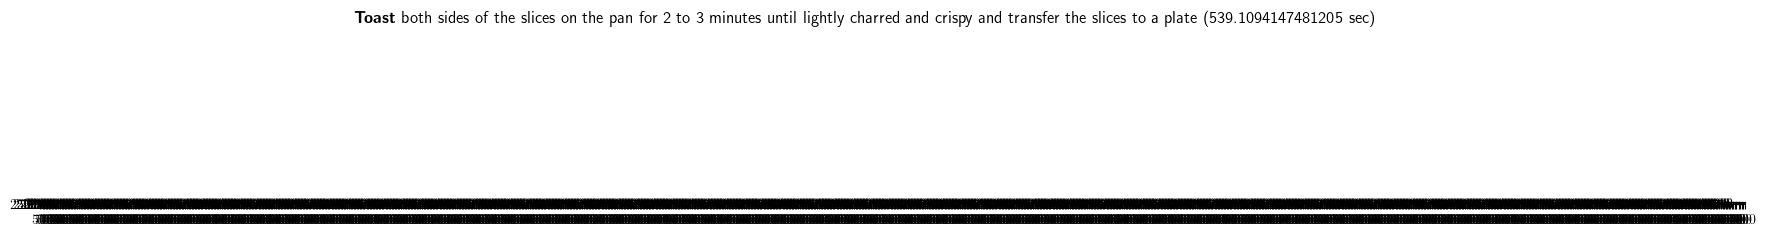

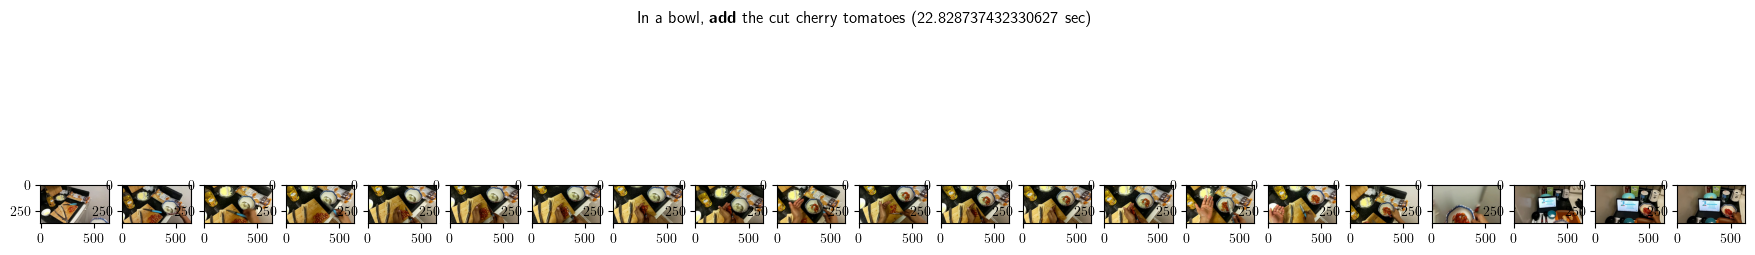

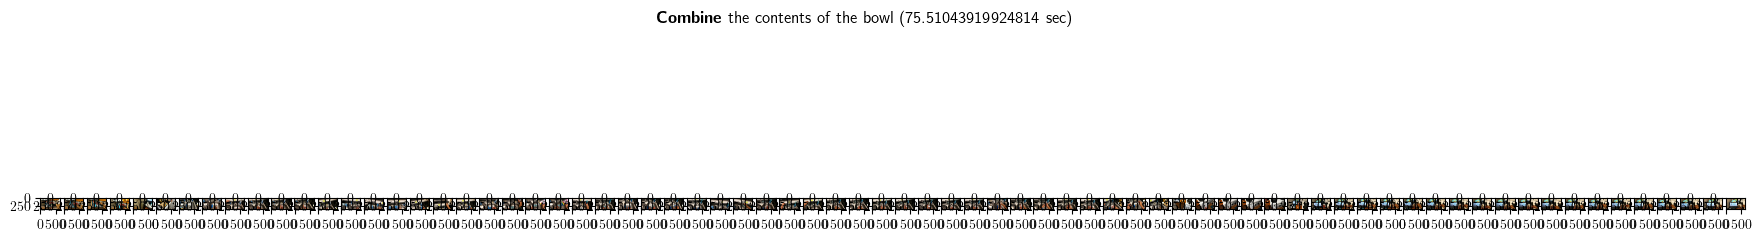

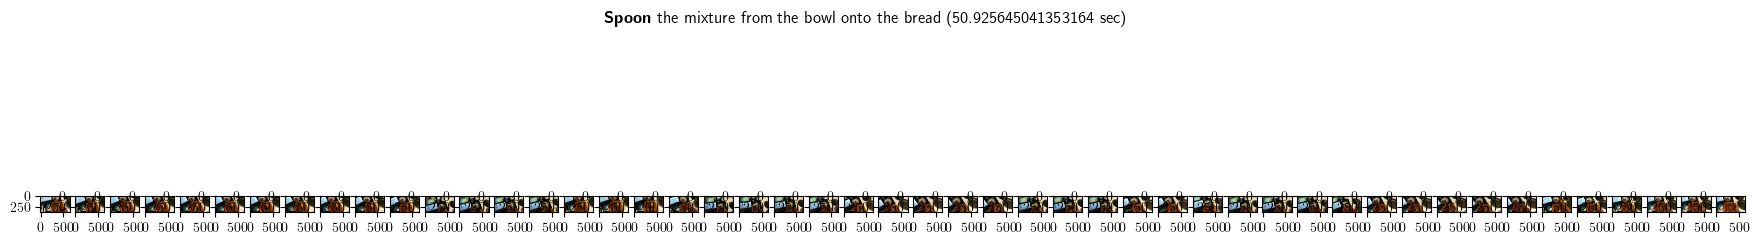

In [6]:
import os, json
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

# Pick a sample video from CaptainCook4D
all_video_files = os.listdir(VIDEO_DIR)
sample_video_path = [f for f in all_video_files if f.endswith('.mp4')][3]
sample_video_id = "_".join(sample_video_path.split('_')[:2])
sample_video_path = os.path.join(VIDEO_DIR, sample_video_path)
print("Sample video:", sample_video_path)
sample_video = get_video(sample_video_path)

step_annotations = json.load(open(os.path.join(ANNOTATIONS_DIR, "annotation_json/complete_step_annotations.json"), "r"))
print("Recipe name:", step_annotations[sample_video_id]["activity_name"])

all_frames = []

# Load step annotations for it and display precondition/effect frames
for step in step_annotations[sample_video_id]["steps"]:
    # Extract some keyframes for the action
    pnr = (step['start_time'] + step['end_time']) / 2.0 # take "point of no return" as midpoint of action
    step_duration = step['end_time'] - step['start_time']

    # Some steps are skipped
    if step_duration < 0.1:
        continue

    # TODO: this method of adjusting the start and end times still doesn't account for noise in labels. Maybe we can use segment anything or GLIP to smooth this a bit later.
    # ^ however, we might just end up running a model on several frames, e.g., 1s apart, so this may not matter - just for illustration purpose for now
    adjusted_start = step['start_time'] + min(step_duration * 0.05, 0.5) # Adjust the start time to be later by a maximum of 3 seconds
    adjusted_end = step['end_time'] - min(step_duration * 0.3, 3) # Adjust the end time to be earlier by a maximum of 3 seconds

    # times = [adjusted_start, pnr, adjusted_end]
    SAMPLE_FREQUENCY = 1.0
    times = generate_float_series(adjusted_start, adjusted_end, SAMPLE_FREQUENCY) # ultimately, we'll want to look at every image frame in some regular interval to determine if there's a mistake
    frames = extract_frames(sample_video, times) 

    fig, axarr = plt.subplots(1, len(times), figsize=(22, 4))

    verb, action_description = step['description'].split("-")[0], "-".join(step['description'].split("-")[1:])
    stylized_title = action_description.replace(verb, r'\textbf{' + verb + '}')

    fig.suptitle(f"{stylized_title} ({step_duration} sec)")
    for frame, ax in zip(frames, axarr):
        if frame is not None:
            ax.imshow(frame)
    plt.show()
    
    all_frames.append(frames)

sample_video.release()

# Find and save target frames

In [7]:
from PIL import Image

target_frames = [
    all_frames[8][5],
    all_frames[8][10],
    all_frames[8][15]
]

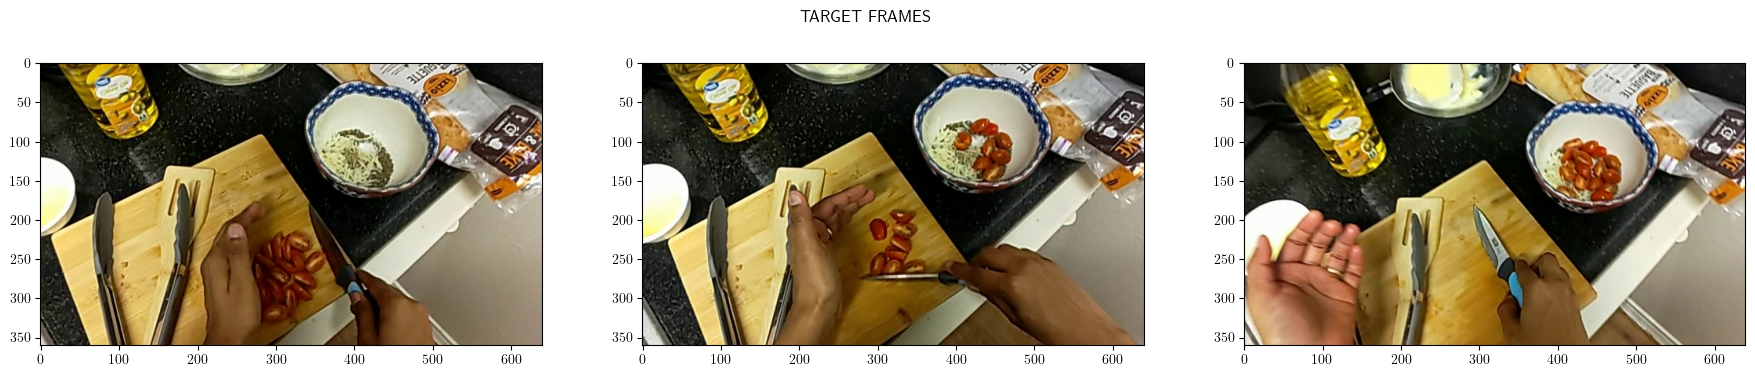

In [8]:
fig, axarr = plt.subplots(1, len(target_frames), figsize=(22, 4))
fig.suptitle("TARGET FRAMES")
for frame, ax in zip(target_frames, axarr):
    if frame is not None:
        ax.imshow(frame)
plt.show()

In [9]:
for fi, frame in enumerate(target_frames):
    Image.fromarray(frame).save(f"./cache_dir/demo_frame{fi}.png")

# Load model

In [10]:
# MODEL_TYPE = "blip2"
# MODEL_TYPE = "instructblip"
# MODEL_TYPE = "kosmos2"
MODEL_TYPE = "llava"

In [11]:
from transformers import AutoProcessor, AutoModelForVision2Seq, LlavaForConditionalGeneration
from transformers import Blip2Processor, Blip2Model, Blip2ForConditionalGeneration

if MODEL_TYPE == "blip2":
    MODEL_NAME = "Salesforce/blip2-flan-t5-xxl"
    processor = Blip2Processor.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
    model = Blip2ForConditionalGeneration.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, cache_dir=CACHE_DIR, load_in_8bit=True) # Automatically put on GPU with load_in_8bit option
elif MODEL_TYPE == "instructblip":
    MODEL_NAME = "Salesforce/instructblip-flan-t5-xxl"
    processor = AutoProcessor.from_pretrained(MODEL_NAME)
    model = AutoModelForVision2Seq.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR, load_in_8bit=True)
elif MODEL_TYPE == "kosmos2":
    MODEL_NAME = "microsoft/kosmos-2-patch14-224"
    model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224", cache_dir=CACHE_DIR, load_in_8bit=True)
    processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")
    from travel.data.utils.image import draw_entity_boxes_on_image
elif MODEL_TYPE == "llava":
    MODEL_NAME = "llava-hf/llava-1.5-7b-hf"
    processor = AutoProcessor.from_pretrained(MODEL_NAME)
    model = LlavaForConditionalGeneration.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR, load_in_8bit=True)    

model.eval()
print(model.device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

cuda:0


# VQA demo

Open generation from prompt:

MODEL: llava
USER:  
What is happening in this photo? 
ASSISTANT: This is a photo of  a person preparing food in a kitchen. The person is cutting up tomatoes on a cutting board, and there are multiple tomatoes spread across the cutting board. The person is using a knife to cut the tomatoes, and there is a bowl nearby, possibly containing other ingredients or used for serving the prepared dish. The scene captures the process of food preparation and the person's involvement in the task.



MODEL: llava
USER:  
What is happening in this photo? 
ASSISTANT: This is a photo of 2 people in a kitchen, preparing food. One person is cutting tomatoes on a cutting board, while the other person is standing nearby. There are multiple bowls on the counter, with one containing tomatoes and another containing cheese. A knife is also visible on the counter, likely used for cutting the tomatoes. The scene depicts a casual and cozy atmosphere, with the individuals working together to prepare a meal.



MO

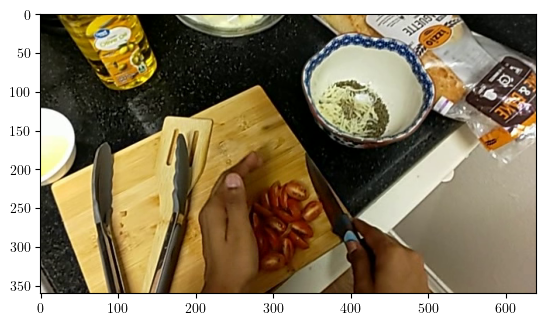

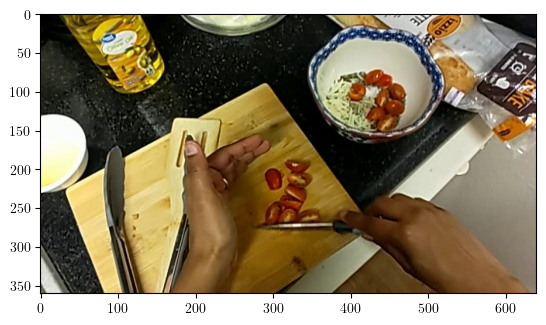

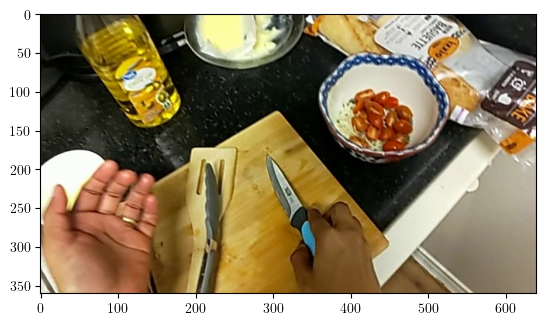

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
from travel.model.vqa import COMPLETION_PROMPT_TEMPLATES

with torch.no_grad():
    
    for input_img in target_frames:
        
        prompt = COMPLETION_PROMPT_TEMPLATES[MODEL_NAME]
        inputs = processor(text=prompt, images=input_img, return_tensors="pt").to(model.device)

        print("MODEL:", MODEL_TYPE)

        if MODEL_TYPE == "kosmos2":
            generated_ids = model.generate(
                pixel_values=inputs["pixel_values"],
                input_ids=inputs["input_ids"][:, :-1],
                attention_mask=inputs["attention_mask"][:, :-1],
                image_embeds=None, # NOTE: we can input image features directly?
                image_embeds_position_mask=inputs["image_embeds_position_mask"][:, :-1],
                use_cache=True,
                max_new_tokens=30,
            )
            generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
            processed_text, entities = processor.post_process_generation(processed_text)

            print(processed_text.replace(" A:", "\nA:"))
            draw_entity_boxes_on_image(Image.fromarray(input_img), entities, show=True)        
        else:
            generated_ids = model.generate(**inputs, max_length=128)
            generate_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]        
            plt.figure()
            plt.imshow(input_img)
            print(generate_text.replace("ASSISTANT:", "\nASSISTANT:"))  
        print("\n\n")

Measure probability of yes/no:

In [84]:
import torch
def get_no_yes_probs(logits, no_id, yes_id):
    logits = torch.softmax(logits, dim=-1)
    no_logit = logits[-1, no_id]
    yes_logit = logits[-1, yes_id]

    no_yes_sum = no_logit + yes_logit
    no_logit /= no_yes_sum
    yes_logit /= no_yes_sum
    probs = torch.stack((no_logit, yes_logit), dim=0).detach().cpu()        
    return probs

MODEL: llava 

No: 0.035678546875715256
Yes: 0.9643214344978333

No (prior, no question + no image): 0.12549345195293427
Yes (prior, no question + no image): 0.8745065927505493

No (normalized): 0.20497772097587585
Yes (normalized): 0.7950222492218018



No: 0.08945460617542267
Yes: 0.9105454087257385

No (prior, no question + no image): 0.12549345195293427
Yes (prior, no question + no image): 0.8745065927505493

No (normalized): 0.4063907563686371
Yes (normalized): 0.5936092734336853



No: 0.16132022440433502
Yes: 0.8386797308921814

No (prior, no question + no image): 0.12549345195293427
Yes (prior, no question + no image): 0.8745065927505493

No (normalized): 0.5727227330207825
Yes (normalized): 0.42727720737457275





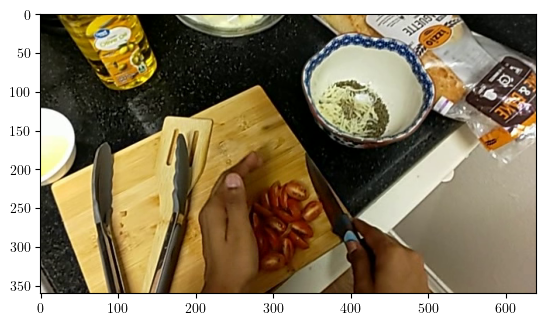

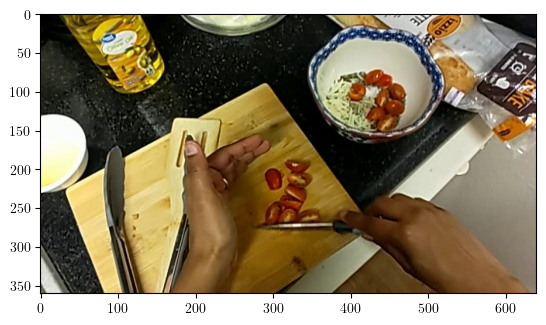

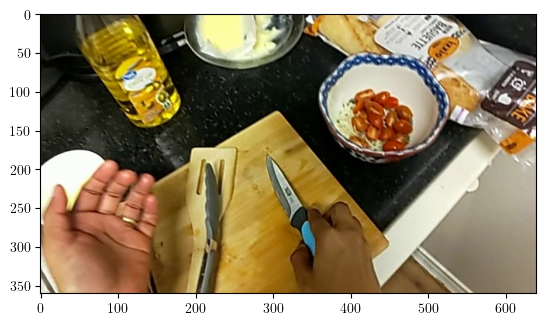

In [101]:
import matplotlib.pyplot as plt
import torch
from travel.model.vqa import VQG2VQA_PROMPT_TEMPLATES, SUCCESSVQA_PROMPT_TEMPLATES, VQAResponse, _shift_right

NO_ID = processor.tokenizer("No", add_special_tokens=False)['input_ids'][0]
YES_ID = processor.tokenizer("Yes", add_special_tokens=False)['input_ids'][0]

step = "In a bowl, add the cut cherry tomatoes"
questions = [
    "Are there any cherry tomatoes in the bowl?",
    "Are there any cherry tomatoes that are not in the bowl?"
]
answers = [VQAResponse.Yes, VQAResponse.No]

step_masked = "In a <pad>, <pad> the <pad> <pad>"
questions_masked = [
    "Are there any <pad> in the <pad>?",
    "Are there any <pad> that are not in the <pad>?"
] # It would be interesting if we could replace all these words with their POS, but LM probably can't handle that?

print("MODEL:", MODEL_TYPE, "\n")

for input_img in target_frames:
    with torch.no_grad():

        # prompt = SUCCESSVQA_PROMPT_TEMPLATES[MODEL_NAME].format(step=step)
        # prompt_noq = SUCCESSVQA_PROMPT_TEMPLATES[MODEL_NAME].format(step=step_masked)        
        
        # prompt = VQG2VQA_PROMPT_TEMPLATES[MODEL_NAME].format(question=questions[0]) # Are there any cherry tomatoes in the bowl?
        # prompt_noq = VQG2VQA_PROMPT_TEMPLATES[MODEL_NAME].format(question=questions_masked[0])
        
        prompt = VQG2VQA_PROMPT_TEMPLATES[MODEL_NAME].format(question=questions[1]) # Are there any cherry tomatoes that are not in the bowl?
        prompt_noq = VQG2VQA_PROMPT_TEMPLATES[MODEL_NAME].format(question=questions_masked[1])
        
        prompt = prompt.replace("yes/no","")
        prompt_noq = prompt_noq.replace("yes/no", "")
        
        inputs = processor(text=prompt, images=input_img, return_tensors="pt").to(device)

        if MODEL_TYPE == "blip2":
            decoder_input_ids = _shift_right(inputs['input_ids'], model.config.text_config.decoder_start_token_id, model.config.text_config.pad_token_id)
            inputs['decoder_input_ids'] = decoder_input_ids

        # Model forward pass
        logits = model(**inputs).logits[0] # (seq length, vocab size)
        probs = get_no_yes_probs(logits, NO_ID, YES_ID)
        
        # Estimate prior probability of yes and no for this sequence (using a prompt without the image and with a masked out version of the question)
        inputs = processor(text=prompt_noq, images=input_img, return_tensors="pt").to(device)
        del inputs['pixel_values']
        logits = model.language_model(**inputs).logits[0]
        probs_prior_noq_noimg = get_no_yes_probs(logits, NO_ID, YES_ID)
                         
        probs_normalized = probs.clone()
        probs_normalized /= probs_prior_noq_noimg
        probs_normalized_sum = probs_normalized[0] + probs_normalized[1]
        probs_normalized[0] /= probs_normalized_sum
        probs_normalized[1] /= probs_normalized_sum
        
        print(f"No: {probs[0]}\nYes: {probs[1]}\n")
        print(f"No (prior, no question + no image): {probs_prior_noq_noimg[0]}\nYes (prior, no question + no image): {probs_prior_noq_noimg[1]}\n")
        print(f"No (normalized): {probs_normalized[0]}\nYes (normalized): {probs_normalized[1]}\n")

        print("\n")
        plt.figure()
        plt.imshow(input_img)

In [87]:
print([processor.tokenizer.decode(t) for t in inputs['input_ids'][0]])

NEWLINE_ID = processor.tokenizer.encode("\n", add_special_tokens=False)[1] # tokenized into two tokens, but the second one is indicative of \n
print(NEWLINE_ID)

QMARK_ID = processor.tokenizer.encode("bowl?", add_special_tokens=False)[2] # question mark token at the end of a word is different than question mark by itself
print(QMARK_ID)

PAD_ID = processor.tokenizer.pad_token_id

print(inputs)

pad_start_index = (inputs['input_ids'][0] == NEWLINE_ID).nonzero(as_tuple=True)[0][0].detach().cpu().numpy() + 1
print(pad_start_index)
print((inputs['input_ids'][0] == QMARK_ID).nonzero(as_tuple=True))
pad_end_index = (inputs['input_ids'][0] == QMARK_ID).nonzero(as_tuple=True)[0][0].detach().cpu().numpy() - 1
print(pad_end_index)
masked_input_ids = torch.tensor([PAD_ID if ti >= pad_start_index and ti <= pad_end_index else tid for ti, tid in enumerate(inputs['input_ids'][0])]).unsqueeze(0)

print(inputs['input_ids'].shape)
print(masked_input_ids.shape)

['<s>', 'US', 'ER', ':', '', '<pad>', '', '\n', 'Are', 'there', 'any', 'cher', 'ry', 'tom', 'atoes', 'in', 'the', 'bow', 'l', '?', '()', 'A', 'SS', 'IST', 'ANT', ':', '']
13
29973
{'input_ids': tensor([[    1,  3148,  1001, 29901, 29871, 32001, 29871,    13, 17506,   727,
           738, 14954,   719,  6454, 20452,   297,   278, 12580, 29880, 29973,
          3861,   319,  1799,  9047, 13566, 29901, 29871]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}
8
(tensor([19], device='cuda:0'),)
18
torch.Size([1, 27])
torch.Size([1, 27])


In [ ]:
#         # Mask out question tokens
#         if MODEL_TYPE == "llava":
#             NEWLINE_ID = processor.tokenizer.encode("\n", add_special_tokens=False)[1] # tokenized into two tokens, but the second one is indicative of \n
#             QMARK_ID = processor.tokenizer.encode("bowl?", add_special_tokens=False)[2] # question mark token at the end of a word is different than question mark by itself
#             PAD_ID = processor.tokenizer.pad_token_id

#             pad_start_index = (inputs['input_ids'][0] == NEWLINE_ID).nonzero(as_tuple=True)[0][0].detach().cpu().numpy() + 1
#             pad_end_index = (inputs['input_ids'][0] == QMARK_ID).nonzero(as_tuple=True)[0][0].detach().cpu().numpy() - 1
#             masked_input_ids = torch.tensor([PAD_ID if ti >= pad_start_index and ti <= pad_end_index else tid for ti, tid in enumerate(inputs['input_ids'][0])]).unsqueeze(0)
#         else:
#             raise NotImplementedError(f"Need to implement masking logic for {MODEL_TYPE}.")
#         inputs['input_ids'] = masked_input_ids

In [72]:
# No: 0.010842684656381607
# Yes: 0.2229456603527069

# No (prior, no question): 3.974672290496528e-05
# Yes (prior, no question): 2.6554707801551558e-05

# No (prior, no image): 5.495475124916993e-05
# Yes (prior, no image): 0.0002504130534362048

# No (prior, no question + no image): 0.00013669737381860614
# Yes (prior, no question + no image): 0.00011941891716560349



# No: 0.0016070256242528558
# Yes: 0.38411712646484375

# No (prior, no question): 4.336694473749958e-05
# Yes (prior, no question): 2.620083250803873e-05

# No (prior, no image): 5.495475124916993e-05
# Yes (prior, no image): 0.0002504130534362048

# No (prior, no question + no image): 0.00013669737381860614
# Yes (prior, no question + no image): 0.00011941891716560349



# No: 0.001543047372251749
# Yes: 0.45189356803894043

# No (prior, no question): 9.169060649583116e-05
# Yes (prior, no question): 4.9505659262649715e-05

# No (prior, no image): 5.495475124916993e-05
# Yes (prior, no image): 0.0002504130534362048

# No (prior, no question + no image): 0.00013669737381860614
# Yes (prior, no question + no image): 0.00011941891716560349

print(" no", 0.010842684656381607 / (3.974672290496528e-05 * 5.495475124916993e-05))
print("yes", 0.2229456603527069 / (2.6554707801551558e-05 * 0.0002504130534362048))

 no 4963982.635421005
yes 33527450.68440069
